Build a wear glass kaggle following the https://www.kaggle.com/jorgebuenoperez/computer-vision-application-of-cnn

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

Note: using Google CoLab


Mount the google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Go to the directory

In [3]:
%cd /content/drive/My Drive/
!ls

/content/drive/My Drive
Model  MyImage	Object


Import needed library

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random


Data Cleaning. 

Glasses

Assign random seed

In [5]:
tf.random.set_seed(123456)

assign batch size and image size

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [7]:
!ls

Model  MyImage	Object


In [8]:
data_dir= "Object"

Setup the training data and testing data. Training Data 70%, Testing Data = 30%

In [9]:
!ls

Model  MyImage	Object


In [10]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 1510 files belonging to 2 classes.
Using 1057 files for training.


In [11]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    shuffle=True,
    seed=123456,
    image_size= IMG_SIZE,
    batch_size=BATCH_SIZE)

Found 1510 files belonging to 2 classes.
Using 453 files for validation.


Display the class type

In [12]:
class_names = train_dataset.class_names
print(class_names)

['Mask', 'NoMask']


Display the desired image type

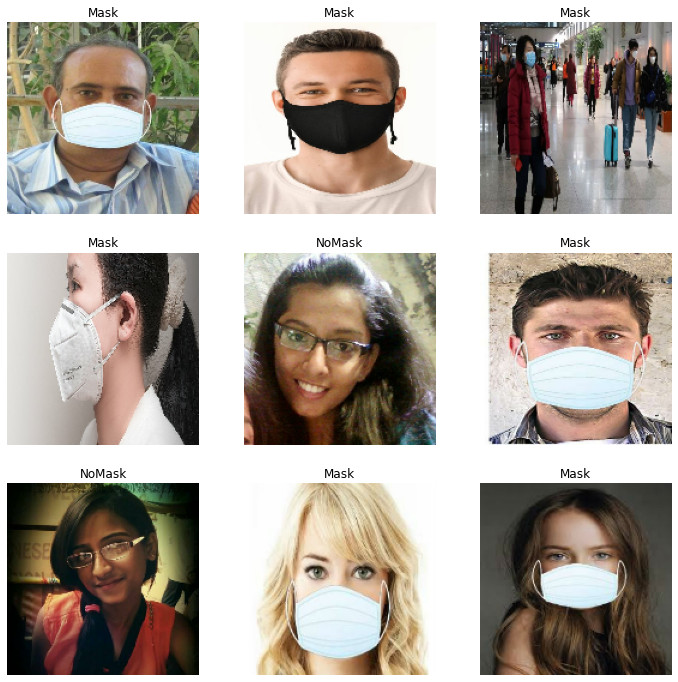

In [13]:
class_names = train_dataset.class_names

plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Currently we have the train_dataset and validation_dataset created, however it is important to have also a small split to test the model, test_dataset. This will be 20% of the validation_dataset, this means, more or less 6%

In [14]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [15]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 34
Number of validation batches: 12
Number of test batches: 3


The Dataset.prefetch() function used in the three splits, overlaps data preprocessing and model execution during the training process

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

3. Prepare the base model

3.1 Data augmentation. Use to introduce artificial observation to the training sample

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

Show the result of the image augmentation

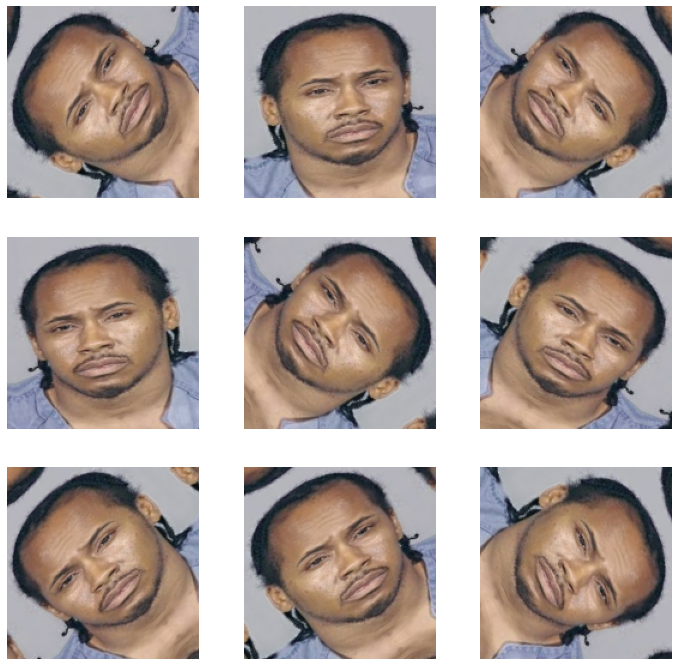

In [18]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

3.2 Rescale the pixel values

Will be using mobile.net 

In [19]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

The model expect value 0 and 1. Input need to preprocessed.

In [20]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

3.3 Create base model for mobile.netN

Should include include_top= false so that classification layer created by mobile.net will be included.

In [21]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


This feature extractor convert images from 160x160x3 to 5 x 5 x 1280

In [22]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Feature Extraction

First of all, we should freeze the convolutional base created from the previous step, because it is going to be used as a feature extractor

In [23]:
base_model.trainable = False

Adding classification head

The layer tf.keras.layers.GlobalAveragePooling2D is going to be used, in order to convert the features in a 1280-element vector, per each image

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


tf.keras.layers.Dense is a layer that converts the features into a single prediction

In [25]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


It is time to apply the previous process to the model:

*   Rescaling
*   Data Augmentation
*   Base Model
*   Feature Extractor


In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

Compilation of the model

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

There are two variable objects. Divided between around 2.5 million of MobilNet parameters which are frozen, and 1.2 thousend of trainable parameter in the Dense layer

In [29]:
len(model.trainable_variables)

2

Train the model

In [30]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

12/12 [==============================] - 25s 340ms/step - loss: 1.1253 - accuracy: 0.3782


In [31]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.13
initial accuracy: 0.38


In [32]:
model_fit = model.fit(train_dataset,
                    epochs= initial_epochs,
                    validation_data= validation_dataset)

Epoch 1/10
34/34 [==============================] - 44s 1s/step - loss: 0.9444 - accuracy: 0.5005 - val_loss: 0.7748 - val_accuracy: 0.5938
Epoch 2/10
34/34 [==============================] - 5s 128ms/step - loss: 0.7284 - accuracy: 0.6405 - val_loss: 0.6624 - val_accuracy: 0.7087
Epoch 3/10
34/34 [==============================] - 5s 125ms/step - loss: 0.6351 - accuracy: 0.6859 - val_loss: 0.6108 - val_accuracy: 0.7171
Epoch 4/10
34/34 [==============================] - 5s 128ms/step - loss: 0.5828 - accuracy: 0.7152 - val_loss: 0.5262 - val_accuracy: 0.7339
Epoch 5/10
34/34 [==============================] - 5s 126ms/step - loss: 0.5190 - accuracy: 0.7379 - val_loss: 0.4691 - val_accuracy: 0.7675
Epoch 6/10
34/34 [==============================] - 5s 127ms/step - loss: 0.4593 - accuracy: 0.7739 - val_loss: 0.4167 - val_accuracy: 0.7787
Epoch 7/10
34/34 [==============================] - 5s 125ms/step - loss: 0.4231 - accuracy: 0.7938 - val_loss: 0.3603 - val_accuracy: 0.8263
Epoch 8/

In [33]:
acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
loss_ = model_fit.history['loss']
val_loss_ = model_fit.history['val_loss']

3.8 Results

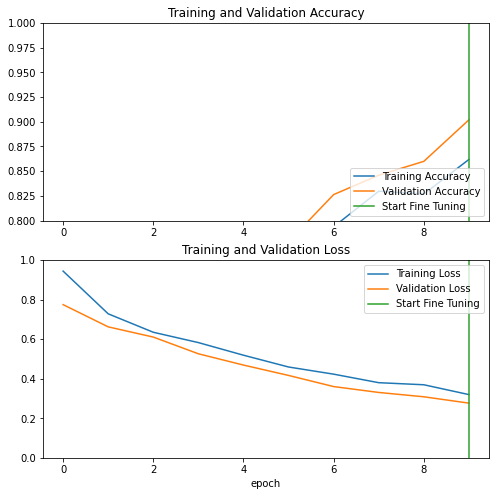

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

As it can be seen in the graphs the accuracy along the 10 epochs was really similar for the validation and training samples
However, it seems that for some epochs the model works slighty better in the validation sample than in the training sample. This probably happened due to the application of some layers like tf.keras.layers.BatchNormalization and tf.keras.layers.Dropout, which are applied during the training process

In [35]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)

34/34 [==============================] - 4s 83ms/step - loss: 0.2802 - accuracy: 0.8685
Test accuracy : 0.8645833134651184
Train accuracy : 0.868495762348175


4) Model with fine tuning

This model is a continuation of the Model 1, however, a fine tunningprocess will be applied in order to increase the performance
During the previos process the weights of the pre-trained network were not updated during the training.
However, it is possible to increase the performance applying these weights

4.1) Unfreeze the top layer of the model

In [36]:
base_model.trainable = True

In [37]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

Number of layers in the base model:  154


4.2 Compile the model

In [38]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [39]:
len(model.trainable_variables)

56

4.3 Training the model

In [40]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

model_fit_fine = model.fit(train_dataset,
                         epochs= total_epochs,
                         initial_epoch= model_fit.epoch[-1],
                         validation_data= validation_dataset)

Epoch 10/15
34/34 [==============================] - 12s 154ms/step - loss: 0.1542 - accuracy: 0.9423 - val_loss: 0.0696 - val_accuracy: 0.9888
Epoch 11/15
34/34 [==============================] - 5s 130ms/step - loss: 0.0628 - accuracy: 0.9820 - val_loss: 0.0412 - val_accuracy: 0.9916
Epoch 12/15
34/34 [==============================] - 5s 129ms/step - loss: 0.0476 - accuracy: 0.9839 - val_loss: 0.0158 - val_accuracy: 0.9972
Epoch 13/15
34/34 [==============================] - 5s 128ms/step - loss: 0.0331 - accuracy: 0.9905 - val_loss: 0.0239 - val_accuracy: 0.9916
Epoch 14/15
34/34 [==============================] - 5s 127ms/step - loss: 0.0275 - accuracy: 0.9896 - val_loss: 0.0216 - val_accuracy: 0.9916
Epoch 15/15
34/34 [==============================] - 5s 129ms/step - loss: 0.0251 - accuracy: 0.9915 - val_loss: 0.0216 - val_accuracy: 0.9944


In [41]:
acc += model_fit_fine.history['accuracy']
val_acc += model_fit_fine.history['val_accuracy']
loss_ += model_fit_fine.history['loss']
val_loss_ += model_fit_fine.history['val_loss']

4.4 Results

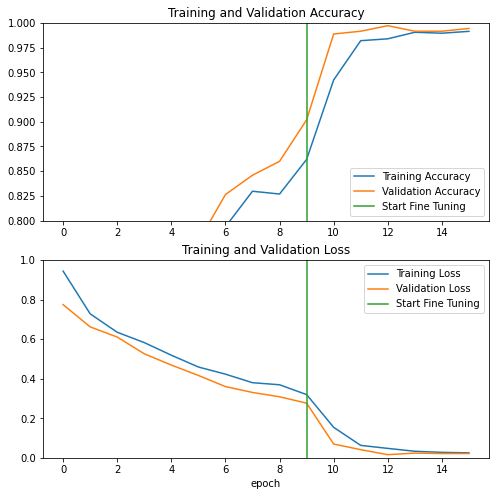

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss_, label='Training Loss')
plt.plot(val_loss_, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [43]:
loss, accuracy = model.evaluate(test_dataset)
loss, accuracy1 = model.evaluate(train_dataset)
loss, accuracy2 = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)
print('Train accuracy :', accuracy1)
print('Validation accuracy :', accuracy2)

12/12 [==============================] - 1s 38ms/step - loss: 0.0302 - accuracy: 0.9916
Test accuracy : 1.0
Train accuracy : 0.9981078505516052
Validation accuracy : 0.9915966391563416


As it can be seen in the training and testsamples the accuracy is really high, greater than 0.99, hence this model is robust and works really well

5) Prediction

In this case the Model 2 with fine tuning will be applied, as the performance of the same was better. The prediction is going to be done in the test sample

Predictions:
 [0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1]
Labels:
 [0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 1]


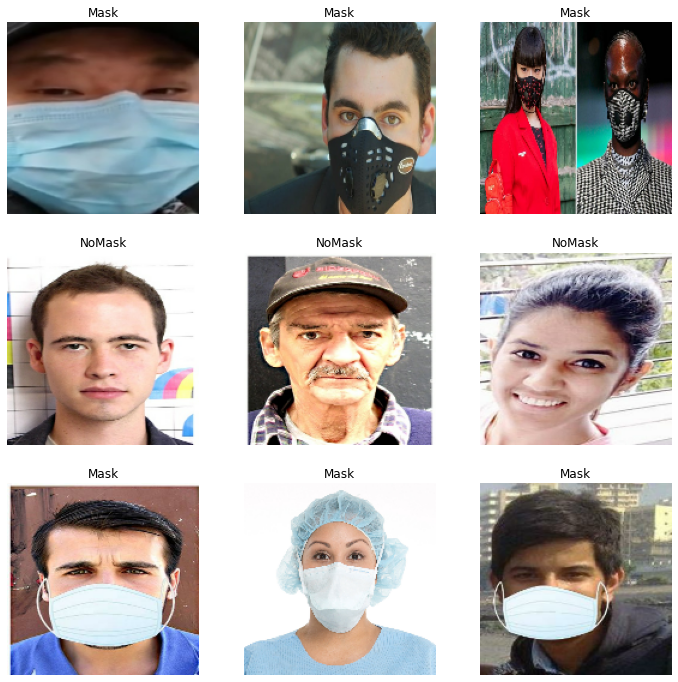

In [44]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(12, 12))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

As per the results, it looks like that the model classified perfectly the images, it can be seen that the array of Predictions is the same as Labels

In [45]:
!ls

Model  MyImage	Object


0
MyImage/1.jpg
tf.Tensor(0.99939764, shape=(), dtype=float32)
tf.Tensor(1, shape=(), dtype=int32)
1
MyImage/2.jpg
tf.Tensor(0.04100181, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32)
2
MyImage/3.jpg
tf.Tensor(0.07039355, shape=(), dtype=float32)
tf.Tensor(0, shape=(), dtype=int32)


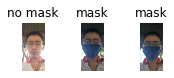

In [46]:
from keras.preprocessing import image

ImageDir = "MyImage/"
ran_num = []
plt.figure(figsize=(3, 3))

for i in range(3):
    ax= plt.subplot(3, 3, i + 1)
    print(i)
    imagePath = ImageDir + str(i+1) + ".jpg"
    print(imagePath)
    plt.imshow(mpimg.imread(imagePath))
    test_image = image.load_img(imagePath, target_size = (160, 160))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = model.predict(test_image)
    prediction = tf.nn.sigmoid(result[0][0])
    print(prediction)
    prediction = tf.where(prediction < 0.5, 0, 1)
    print(prediction)
    #training_set.class_names

    
    if prediction == 0:
      plt.title("mask")
    else:
      plt.title("no mask")
    plt.axis("off")




In [47]:
model.save("Model/mask_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
